In [1]:
run run_residuals -vg -o 2 -l 50,200

rm clusters/pickes/*.pkl

Initialization runtime 7.46 s
Number of stars 484

Nonzero Minimum SNR before mask 50.0000
Maximum SNR before correction 200.00
SNR cut runtime 0.00 s
Minimum SNR after mask 50.0000
Maximum SNR after correction 200.00

SNR correction runtime 0.05 s

Bitmask application runtime 0.00 s

Pixel residuals runtime 0.29 s
Maximum residual 0.1938813389 

Finding random sigma runtime 0.28 s



/Users/Natalie/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


In [2]:
ocmodel1 = acs.pklread('clusters/pickles/models/model.pkl')

In [4]:
import numpy as np
import statsmodels.nonparametric.smoothers_lowess as sm
import scipy as sp
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
import matplotlib.patheffects as path_effects
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [66]:
detec_blue =[0,2920]
detec_green = [2920,5320]
detec_red = [5320,7213]
detectors = [0,2920,5320,7214]
def calc_cov(model,subgroups=None):
    """
    Calculates the covariance matrix of fit residuals divided by measurement uncertainty.
    
    If subgroups are given, returns the covariance matrix of combined subgroups as well as each one individually.
    If no subgroups are given, returns one matrix.
    """
    
    if subgroups:
        covs = ()
        totalstars = 0
        for subgroup in subgroups:
            totalstars += model.numstars[subgroup]
        allresids = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
        allerrors = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
        star = 0
        for subgroup in subgroups:
            match = np.where(model.data[model.subgroup]==subgroup)
            res = model.residual[subgroup]
            err = model.errs[match].T
            covs += (np.ma.cov(res/err),)
            allresids[star:star+model.numstars[subgroup]] = res.T
            allerrors[star:star+model.numstars[subgroup]] = err.T
            star+=model.numstars[subgroup]          
    elif not subgroups:
        covs = ()
        allresids = model.residual.T
        allerrors = model.errs
    covs += (np.ma.cov(allresids.T/allerrors.T),)
    return covs

def diagonals(covs):
    """
    Extracts diagonals from a tuple of potentially masked covariance matrices.
    """
    diagonals = ()
    for cov in covs:
        diagonal = np.ma.masked_array([cov[i,i] for i in range(len(cov))],mask = [cov.mask[i,i] for i in range(len(cov))])
        diagonals += (diagonal,)
    return diagonals
    

def smoothmedian(diags,index=-1,frac=2./3.):
    """
    Uses Locally Weighted Scatterplot Smoothing to smooth an array on each detector separately. Interpolates
    at masked pixels and concatenates the result.
    
    Returns the smoothed median value of the input array, with the same dimension.
    """
    
    diag = diags[index]
    mask = diag.mask==False
    smoothmedian = np.zeros(diag.shape)
    for i in range(len(detectors)-1):
        xarray = np.arange(detectors[i],detectors[i+1])
        yarray = diag[detectors[i]:detectors[i+1]]
        array_mask = mask[detectors[i]:detectors[i+1]]
        low_smooth = sm.lowess(yarray[array_mask],xarray[array_mask],frac=frac,it=3,return_sorted=False)
        smooth_interp = sp.interpolate.interp1d(xarray[array_mask],low_smooth,bounds_error=False)
        smoothmedian[detectors[i]:detectors[i+1]] = smooth_interp(xarray)
    return smoothmedian
    
def covplots(limit,covs,diags,smoothmedian,clusterlist=None,direc='clusters/covariance/',index=-1,ymax = 10,mask=True,name='',detector=False):
    """
    Plots covariance matrix and its diagonal.
    """
    plt.figure(figsize = (14,12))
    plt.imshow(covs[index],vmin=-limit,vmax=limit,interpolation='nearest',cmap = 'Spectral')
    plt.colorbar(label='covariance')
    plt.xlabel('pixel')
    plt.ylabel('pixel')
    if clusterlist:
        plt.title('combined covariance matrix of {0}'.format(clusterlist))
    elif not clusterlist:
        plt.title('covariance matrix')
    plt.savefig(direc+name+'covariance.png')
    plt.figure(figsize=(12,5))
    if mask:
        for maskedelem in np.where(diags[-1].mask==True)[0]:
            if maskedelem == np.where(diags[-1].mask==True)[0][0]:
                plt.axvline(maskedelem,color='k',label='masked region')
            plt.axvline(maskedelem,color='k')
    plt.plot(np.arange(aspcappix),smoothmedian,'w-',linewidth=3,path_effects=[path_effects.withStroke(linewidth=7, foreground="k")],label='running median')
    plt.plot(diags[index],'.',label='variance of normalized data',alpha=0.25)
    if detector:
        for pixel in detectors:
            plt.axvline(pixel,color='g',linewidth=3)
    plt.ylim(0,ymax)
    plt.xlim(0,aspcappix)
    plt.ylabel('variance')
    plt.xlabel('pixel')
    plt.legend(loc='best')
    if clusterlist:
        plt.title('diagonal of combined covariance matrix of {0}'.format(clusterlist))
    elif not clusterlist:
        plt.title('diagonal of covariance matrix')
    plt.savefig(direc+name+'diag.png')        

In [73]:
clusterlist = ['M67','N6819']
covs = calc_cov(ocmodel1,clusterlist)
diags = diagonals(covs)

In [74]:
smooth_med = smoothmedian(diags,index=-1,frac=1./3.)
limit = 4

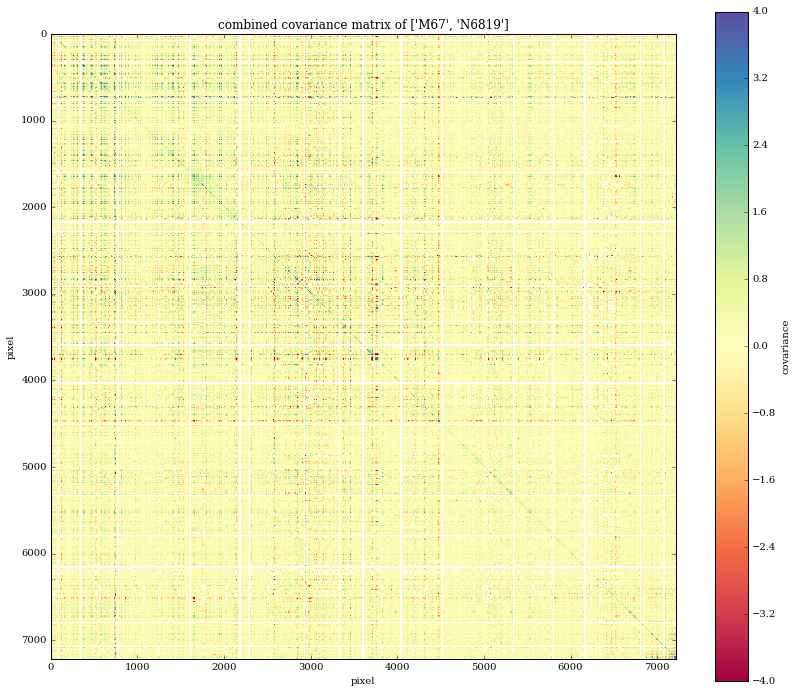

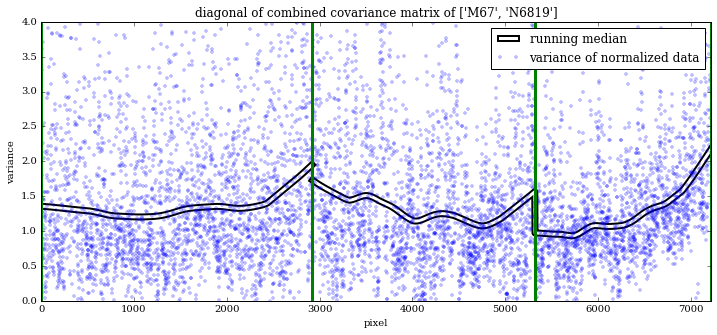

In [75]:
covplots(limit,covs,diags,smooth_med,clusterlist,ymax=4,mask=False,name='precorrection_',detector=True)

In [56]:
acs.pklwrite('pickles/diagonalcorrect.pkl',diags[-1])

In [57]:
run run_residuals -vg -o 2 -C pickles/diagonalcorrect.pkl -l 50,200

rm clusters/pickes/*.pkl
431 Pleiades  File missing
432 Pleiades  File missing
433 Pleiades  File missing
434 Pleiades  File missing
435 Pleiades  File missing
436 Pleiades  File missing
437 Pleiades  File missing
438 Pleiades  File missing
439 Pleiades  File missing
440 Pleiades  File missing
441 Pleiades  File missing
442 Pleiades  File missing
443 Pleiades  File missing
444 Pleiades  File missing
445 Pleiades  File missing
446 Pleiades  File missing
447 Pleiades  File missing
448 Pleiades  File missing
449 Pleiades  File missing
450 Pleiades  File missing
451 Pleiades  File missing
452 Pleiades  File missing
453 Pleiades  File missing
454 Pleiades  File missing
455 Pleiades  File missing
456 Pleiades  File missing
457 Pleiades  File missing
458 Pleiades  File missing
459 Pleiades  File missing
460 Pleiades  File missing
461 Pleiades  File missing
462 Pleiades  File missing
463 Pleiades  File missing
464 Pleiades  File missing
465 Pleiades  File missing
466 Pleiades  File missing
467

In [58]:
ocmodel_corr_name = 'clusters/pickles/models/model_snrCorrect.pkl'
ocmodel2 = acs.pklread(ocmodel_corr_name)

In [69]:
clusterlist = ['M67','N6819']
covs = calc_cov(ocmodel2,clusterlist)
diags = diagonals(covs)
smooth_med = smoothmedian(diags,index=-1)
limit = 4

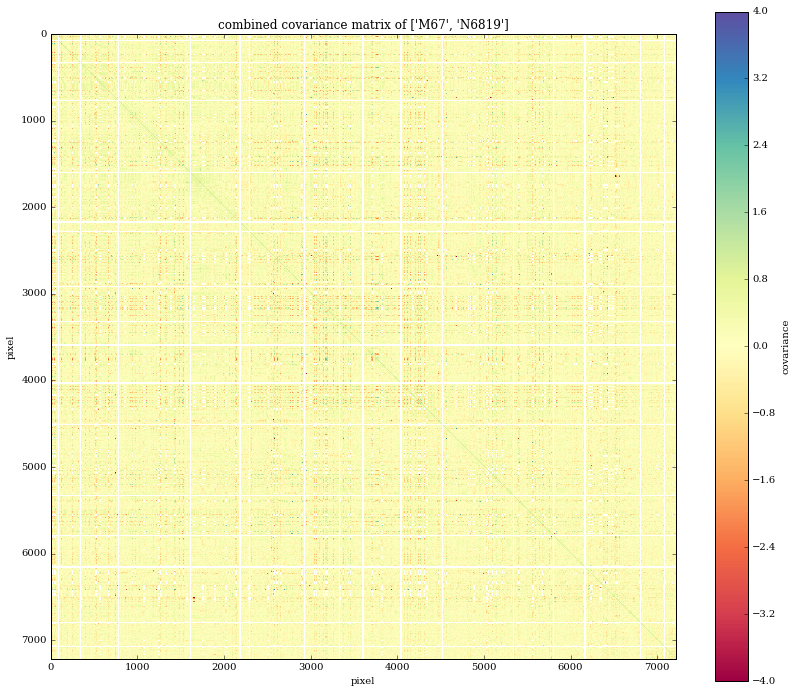

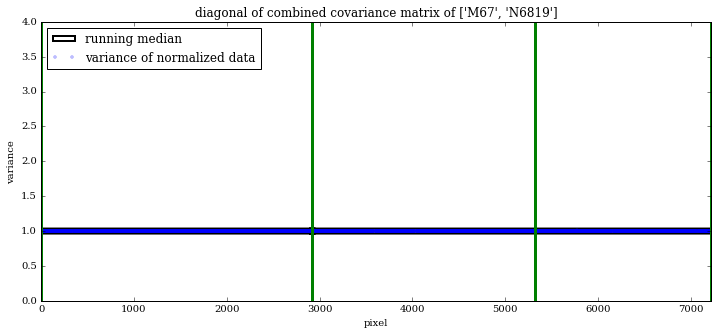

In [70]:
covplots(limit,covs,diags,smooth_med,clusterlist,ymax=4,mask=False,name='postcorrection_',detector=True)

In [61]:
run run_residuals -vgx -i FE_H -u -0.1 -d -0.105 -s red_clump -c None -C pickles/diagonalcorrect.pkl -l 50,200

rm red_clump/pickles/*FE_H*-0.1*-0.105*.pkl

Initialization runtime 3.45 s
Number of stars 194

Nonzero Minimum SNR before mask 0.0012
Maximum SNR before correction 219.82
SNR cut runtime 0.06 s
Minimum SNR after mask 50.0025
Maximum SNR after correction 200.00

SNR correction runtime 0.10 s

Bitmask application runtime 0.13 s

Pixel residuals runtime 238.43 s
Maximum residual 0.189782494696 

Finding random sigma runtime 1.06 s



In [63]:
rcmodelname = starsample.outName('pkl',content = '/models/model')
rcmodel = acs.pklread(rcmodelname)

In [71]:
covs = calc_cov(rcmodel)
diags = diagonals(covs)
smooth_med = smoothmedian(diags,index=-1)
limit = 4

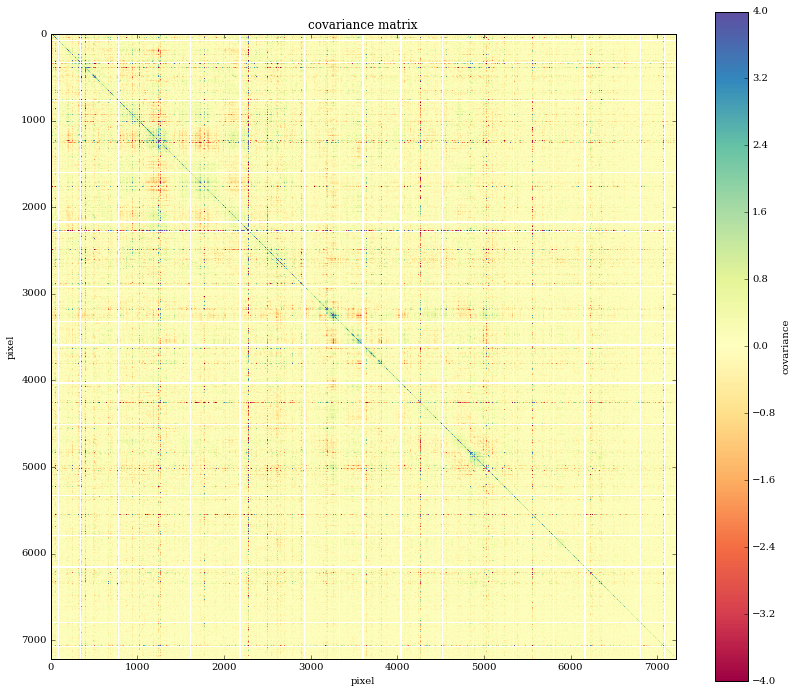

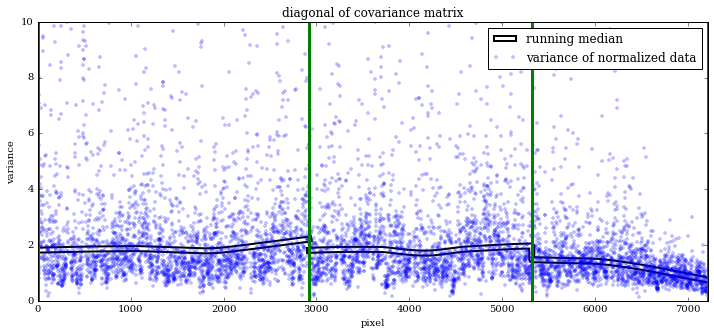

In [72]:
covplots(limit,covs,diags,smooth_med,direc='red_clump/covariance/',mask=False,detector=True)